### libraries

In [1]:
library(orthogene)
library(Seurat)
library(dplyr)
library(ggplot2)
library(ggpubr)
library(viridis)

fig <- function(width, heigth){
 options(repr.plot.width = width, repr.plot.height = heigth)
 }

Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  inner_join.phylo    tidytree
  inner_join.treedata tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

The legacy packages maptools, rgdal, and rgeos, under

### setup

In [8]:
wd <- '~/codebases/MacBrainDev/'
setwd(wd)

dir.create('PCsMarkers', showWarnings = F)

data.dir <- 'data/'

base.name <- 'All.MNN.v1.org.fct'
# Define filename
indata.fname <- paste0(data.dir, base.name, '.rds')
pc.markers.file <- 'DiseaseGenesMarkersExpression/PCs_1/Disease-risk marker gene expression plot.NotExp.0.1.Exp.0.1.csv'

genesets <- readRDS(paste0(data.dir, 'ewce_important_genesets.rds'))

In [3]:
finish_plot_1 <- function(p){
    return(p + 
    geom_point(shape=16) +
    facet_grid(cols=vars(subclass),
               space='free', scales='free') + 
    labs(gene = "Disease",
         x = "Cell subtype",  
         y= 'Gene',
         size='Percentage expressed', 
         color='Average expression') + 

    scale_size_continuous(range=c(2,6)) +

    theme_pubr(base_family='Arial', legend = 'bottom') + labs_pubr() + 

    theme(strip.text.x = element_text(angle = 90, vjust = 0.5, hjust=0.5),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, margin = margin(b=20))) +

    ggtitle(label = "Disease-risk & Patterning Center marker genes' expression") + 

    guides(color = guide_colorbar(title.position = "top", 
                                hjust = 0.5,# centres the title horizontally
                                title.hjust = 0.5,
                                label.position = "bottom"),
           size = guide_legend(title.position = "top", 
                                hjust = 0.5,# centres the title horizontally
                                title.hjust = 0.5,
                                label.position = "bottom")) +

    theme(
          panel.background = element_rect(fill = "#F2F2F2"),
          panel.grid.major = element_line(size = 0.5, linetype = 'solid', colour = "darkgrey")) +
    
    scale_color_gradient(low='lightgrey', high='red')
    # scale_color_viridis(direction=-1, option='magma', guide = "colourbar")
)
}
    

In [4]:
get_dis_plot <- function(genes){

    gene.in.dis <- lapply(genesets$disease_lists.data, function(x) {setNames(genes %in% x, genes)})

    gene.in.dis <- gene.in.dis[sapply(gene.in.dis, any)]

    exclusive.in.disease <- do.call('rbind', lapply(names(gene.in.dis), function(x){
        data.frame(Disease.listname=x, Gene=genes, Risk.gene=gene.in.dis[[x]])
    }))

    exclusive.in.disease$Disease.group <- factor(disease.groups[exclusive.in.disease$Disease.listname], levels=c('GWAS', 'MAGMA', 'DISGENET'))
    exclusive.in.disease$Disease.name <- disease.names[exclusive.in.disease$Disease.listname]
    exclusive.in.disease$Disease.name <- factor(exclusive.in.disease$Disease.name, sort(unique(exclusive.in.disease$Disease.name)))
    
    dis.exc.plot <- ggplot(exclusive.in.disease, 
           aes(x=Disease.name,
               y = factor(Gene, levels=genes),
               fill=Risk.gene)) + 
        facet_grid(cols=vars(Disease.group), scales='free', space='free') + 
        geom_tile(color='black') +
        scale_fill_manual(values=c('TRUE'='black', 'FALSE'='#F2F2F2')) + 
        labs(x = "",
             y = "Gene",  
             fill='Risk gene') + 

        theme_pubr(base_family='Arial', legend = 'none') + labs_pubr() +

        theme(strip.text.x = element_text(angle = 90, vjust = 0.5, hjust=0.5),
              axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +


        guides(fill = guide_legend(title.position = "top", 
                                    hjust = 0.5,# centres the title horizontally
                                    title.hjust = 0.5,
                                    label.position = "right", ncol=1)) +
        theme(panel.background = element_rect(fill = "#F2F2F2"), legend.margin=margin(t=10))

    return(list(p=dis.exc.plot, n=length(unique(exclusive.in.disease$Disease.listname))))
}

### prepare data

In [5]:
# Load data
indata <- readRDS(indata.fname)
# Print summary
indata
# gather info from clusters
clusters <- data.frame(unique(indata@meta.data[,c('subclass','subtype')]))
rownames(clusters) <- clusters$subtype
clusters

# convert human genes to macaque (121 orthologs)
exp.ort <- convert_orthologs(rownames(indata), input_species = 'mmulatta', output_species = 'hsapiens', verbose=T)
head(exp.ort)

data.mm.to.hs <- setNames(rownames(exp.ort), exp.ort$input_gene)
data.hs.to.mm <- setNames(exp.ort$input_gene, rownames(exp.ort))

hsdata <- CreateSeuratObject(counts = indata[['RNA']]@counts[names(data.mm.to.hs),], project = 'hs', assay = 'RNA', meta.data = indata@meta.data, 
                             row.names = data.mm.to.hs, min.cells = 0, min.features = 0)

hsdata <- SetAssayData(object = hsdata, slot = 'data', assay = 'RNA', new.data=indata[['RNA']]@data[names(data.mm.to.hs),])

hsdata

An object of class Seurat 
34619 features across 761529 samples within 1 assay 
Active assay: RNA (34619 features, 0 variable features)
 2 dimensional reductions calculated: mnn, umap

,subclass,subtype
,<fct>,<fct>
Cls FGF17 LGI1,PAT-related subtypes,Cls FGF17 LGI1
RGC FABP7 PMP22,dorsal NSC,RGC FABP7 PMP22
IPC RSPO3 NHLH1,CR,IPC RSPO3 NHLH1
InN SP8 MEIS2 RND3,Inhibitory neurons,InN SP8 MEIS2 RND3
PC NKX2-1 NKX6-2,Patterning centers,PC NKX2-1 NKX6-2
PC FGF17,Patterning centers,PC FGF17
PC NKX2-1 LMO1,Patterning centers,PC NKX2-1 LMO1
vRG HMGA2 CCND1,dorsal NSC,vRG HMGA2 CCND1
IPC RSPO3 NEUROG1,CR,IPC RSPO3 NEUROG1


Preparing gene_df.

character format detected.

Converting to data.frame

Extracting genes from input_gene.

34,619 genes extracted.

Converting mmulatta ==> hsapiens orthologs using: gprofiler

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: mmulatta

1 organism identified from search: mmulatta

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: hsapiens

1 organism identified from search: hsapiens

Checking for genes without orthologs in hsapiens.

Extracting genes from input_gene.

36,866 genes extracted.

Extracting genes from ortholog_gene.

36,866 genes extracted.

Dropping 16,190 NAs of all kinds from ortholog_gene.

Checking for genes without 1:1 orthologs.

Dropping 1,172 genes that have multiple input_gene per ortholog_gene (many:1).

Dropping 1,560 genes that have multiple ortholog_gene per input_gene (1:many).

Filtering gene_df with gene_map

Setting ortholog_gene t

,index,input_gene
,<int>,<chr>
PGBD2,1,PGBD2
ZNF692,4,ZNF692
ZNF672,7,ZNF672
SH3BP5L,9,SH3BP5L
LYPD8,10,LYPD8
OR2T27,17,OR2T27


An object of class Seurat 
17330 features across 761529 samples within 1 assay 
Active assay: RNA (17330 features, 0 variable features)

In [6]:
disease.listnames <- names(genesets$disease_lists.data)

disease.names <- setNames(sapply(strsplit(disease.listnames, split='::'), function(x){rev(x)[1]}), disease.listnames)

disease.groups <- setNames(sapply(strsplit(disease.listnames, split='::'), 
                                 function(x){if (length(x)==2) x[1] else 'GWAS'}), disease.listnames)

In [9]:
bname <- basename(pc.markers.file)

name.split <- strsplit(pc.markers.file, split='.', fixed=T)[[1]]
not.exp <- grep('NotExp', name.split, fixed=T)
min.exp <- as.numeric(paste(name.split[(not.exp+1):(not.exp+2)], collapse='.'))*100

print(pc.markers.file)
print(min.exp)

bname <- basename(pc.markers.file)

pc.markers.df <- read.csv(pc.markers.file, row.names=1)
risk.markers <- sort(unique(strsplit(paste(pc.markers.df$risk.markers, collapse=','), split=',', fixed=T)[[1]]))
risk.markers <- risk.markers[risk.markers!='']
print(length(risk.markers))

my.hsdata <- ScaleData(hsdata, block.size = 10000, features=risk.markers, vars.to.regress = 'nCount_RNA', verbose=T)





dp <- DotPlot(my.hsdata, features=rev(risk.markers), group.by = 'subtype')
dpdata <- dp$data

dpdata$subclass <- clusters[as.character(dpdata$id), 'subclass']

gene.max <- subset(dpdata, subclass == 'Patterning centers' & pct.exp >= min.exp) %>%
    group_by(features.plot) %>% 
    summarize(max.pct = id[order(avg.exp.scaled, decreasing = T)][1])

gene.order <- rev(unname(unlist(split(gene.max$features.plot, gene.max$max.pct)[levels(droplevels(subset(clusters, subclass=='Patterning centers' )$subtype))])))

dpdata$features.plot <- factor(dpdata$features.plot, levels=gene.order)

subclass.dont.count <- c('Mes', 'Patterning centers', 'RB&Vas', 'Immune')
if(!all(subclass.dont.count %in% unique(dpdata$subclass))){stop()}

gene.per.cluster.exp <- subset(dpdata, 
                               !subclass %in% subclass.dont.count) %>%
    group_by(id, features.plot) %>% 
    summarise(exp=pct.exp >= 10)

gene.exp <- gene.per.cluster.exp %>% 
    group_by(features.plot) %>% 
    summarize(exp=sum(exp), exclusive=sum(exp)<=3)

genes.exclusive <- subset(gene.exp, exclusive)$features.plot

message(bname)
print('- Exclusive genes:')
print(genes.exclusive)



# expression   
exp.plot.scaled <- finish_plot_1(ggplot(dpdata, 
                  aes(x=id,
                      y=features.plot,
                      size=ifelse(pct.exp < min.exp, NA, pct.exp),
                      color=avg.exp.scaled)) ) + ggtitle(label = "Disease-risk & Patterning Center marker genes' expression",
                                                         subtitle=paste0('Minimum expression shown: ', min.exp, '% of cells')) 

ggsave(exp.plot.scaled, 
       filename = paste0('PCsMarkers/', 'MarkersExpression.pdf'),
       width = 22, height = 27, limitsize = FALSE, useDingbats=FALSE)

# diseases
dis.exc.plot.list <- get_dis_plot(gene.order)
dis.n <- dis.exc.plot.list$n
dis.exc.plot <- dis.exc.plot.list$p


combined.plot <- cowplot::plot_grid(
    dis.exc.plot + theme(axis.text.y = element_blank()),
    exp.plot.scaled + ylab(''),
    rel_widths=c(4,13),
    align = 'h', axis = 'lbt')

cowplot::save_plot(combined.plot, filename='Supp.16.C.pdf',
                    base_height = 27, base_width = 30, limitsize = FALSE, useDingbats=FALSE)


# expression exclusive
exp.plot.scaled.top <- finish_plot_1(ggplot(filter(dpdata, features.plot %in% genes.exclusive), 
                  aes(x=id,
                      y=features.plot,
                      size=ifelse(pct.exp < min.exp, NA, pct.exp),
                      color=avg.exp.scaled)) ) + ggtitle(label = "Disease-risk & Patterning Center marker genes' expression",
                                                         subtitle=paste0('Minimum expression shown: ', min.exp, '% of cells')) 

ggsave(exp.plot.scaled.top, 
       filename = paste0('PCsMarkers/', 'ExclusiveMarkersExpression.pdf'),
       width = 22, height = 10, limitsize = FALSE, useDingbats=FALSE)

# diseases
dis.exc.plot.list.top <- get_dis_plot(genes.exclusive)
dis.n.top <- dis.exc.plot.list.top$n
dis.exc.plot.top <- dis.exc.plot.list.top$p


combined.plot.top <- cowplot::plot_grid(
    dis.exc.plot.top + theme(axis.text.y = element_blank()),
    exp.plot.scaled.top + ylab(''),
    rel_widths=c(2.7,13),
    align = 'h', axis = 'lbt')

cowplot::save_plot(combined.plot.top, filename='Fig.7.B.pdf',
                    base_height = 10, base_width = 25, limitsize = FALSE, useDingbats=FALSE)


[1] "DiseaseGenesMarkersExpression/PCs_1/Disease-risk marker gene expression plot.NotExp.0.1.Exp.0.1.csv"
[1] 10
[1] 127


Regressing out nCount_RNA

Centering and scaling data matrix

`summarise()` has grouped output by 'id'. You can override using the `.groups`
argument.
Disease-risk marker gene expression plot.NotExp.0.1.Exp.0.1.csv



[1] "- Exclusive genes:"
 [1] CA14    RNF43   SHOX2   WNT3    WNT4    ADA     BCAM    CADPS2  CGNL1  
[10] CNN2    EMB     GRM8    KCNJ13  MECOM   MET     MYB     ORAI3   SAMD11 
[19] SLC29A4 SLC7A5  SLC7A6  SPATA33 EFHD1   SLC35D2 FGF8    LYN    
127 Levels: BCHE CA14 CSPG5 DLG1 GRID2 JAG1 MTMR2 NAV2 NTNG1 OTX1 ... SERPING1


Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Removed 10569 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 10569 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2819 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2819 rows containing missing values (`geom_point()`).”


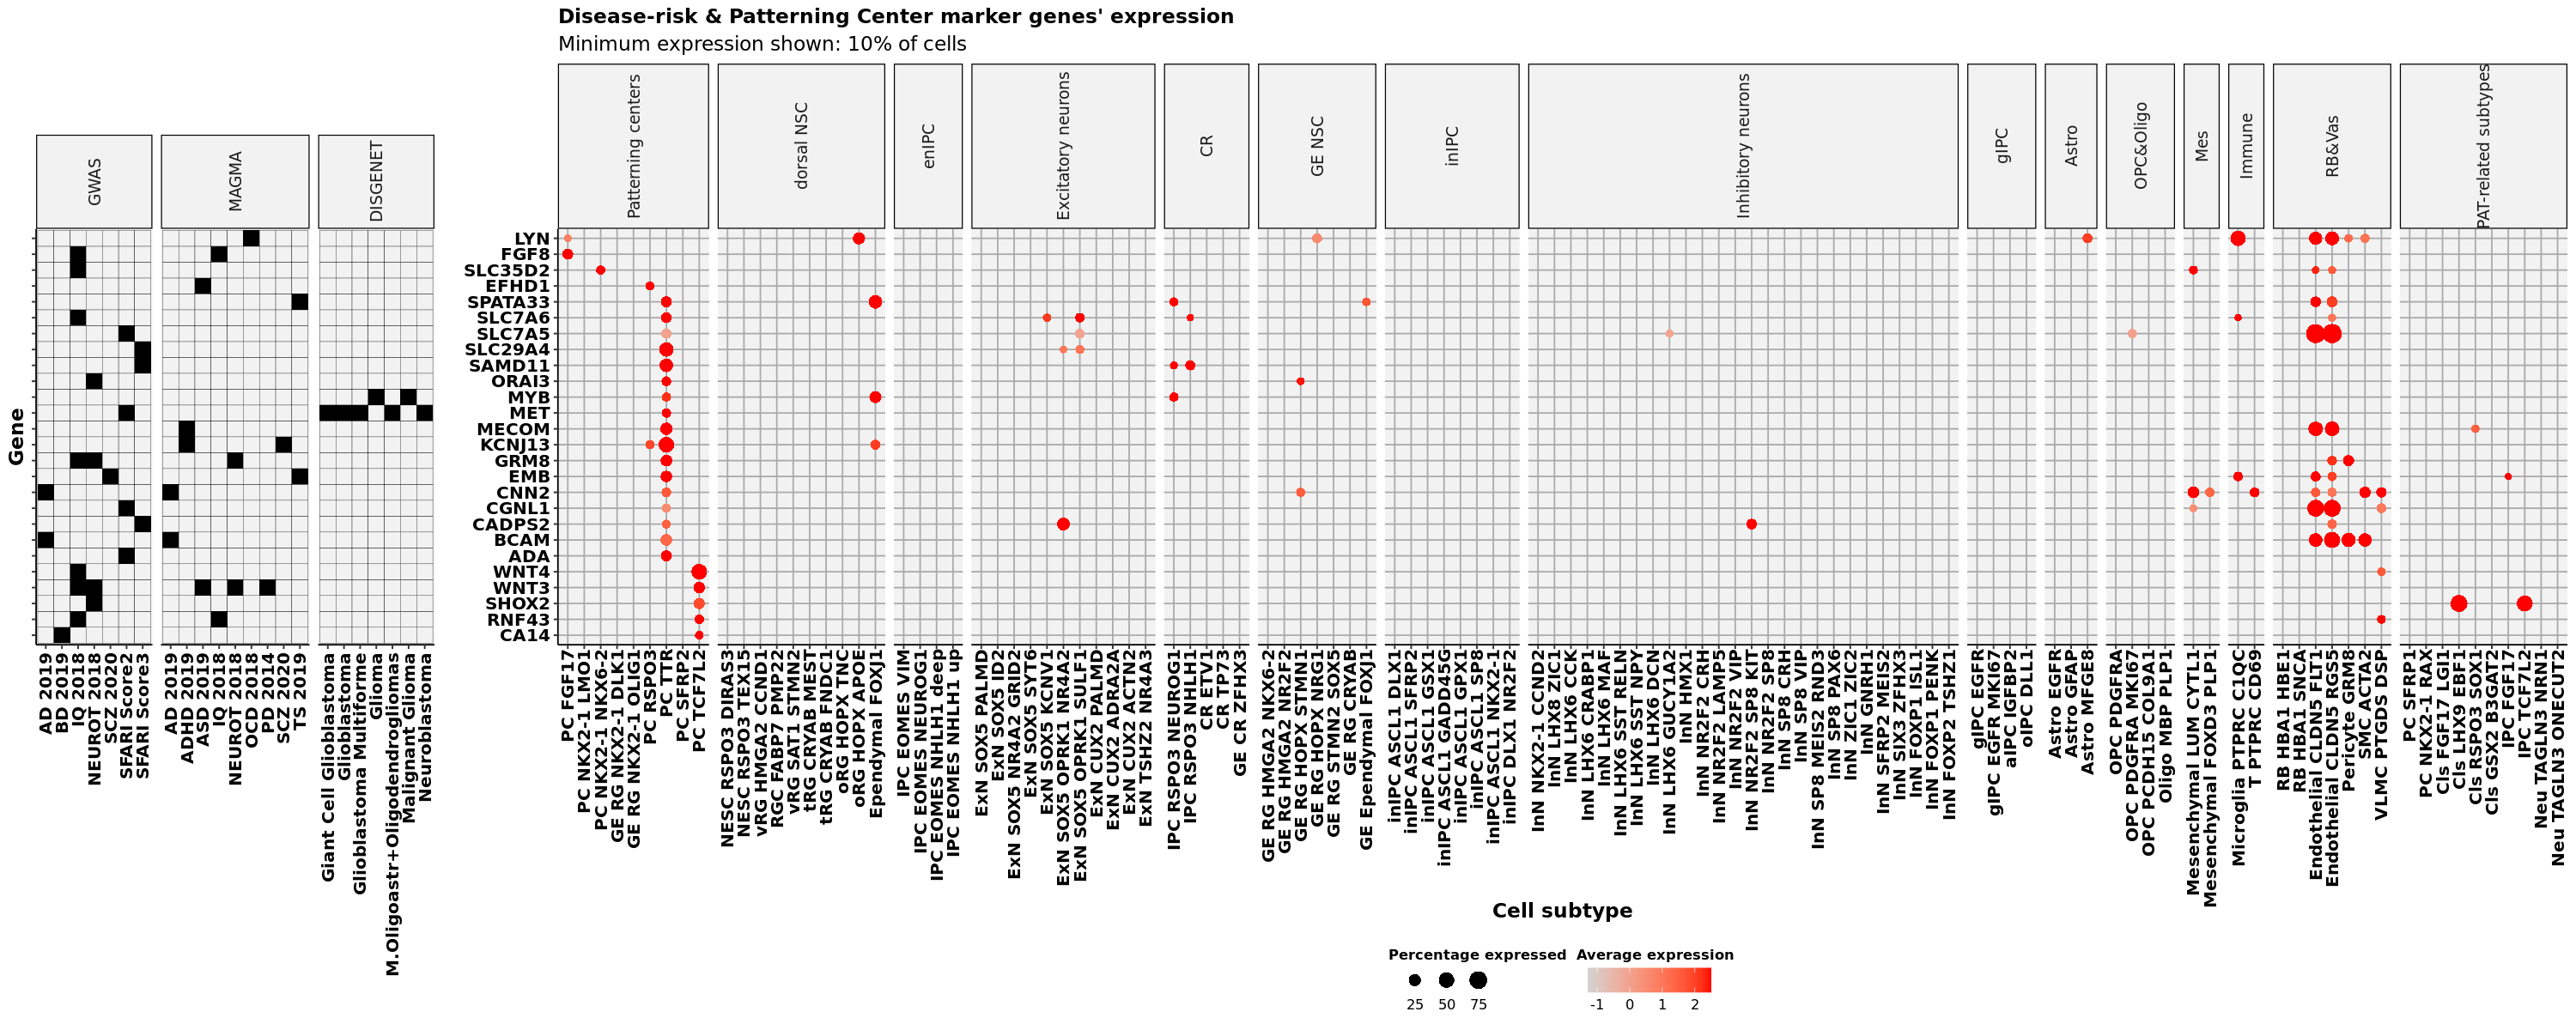

In [11]:
fig(25,10)

combined.plot.top